In [1]:
#Importing packages
from cv2 import imread, resize, CascadeClassifier, fastNlMeansDenoising, imwrite
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
#The OCL database of faces consists of ten different images of each of 40 distinct subjects. For some subjects, the images were 
#taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details
#(glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal 
#position (with tolerance for some side movement).

imgname_train = [[0 for i in range(8)] for j in range(40)] #Take 8 images of each person in training set
imgname_test = [[0 for i in range(2)] for j in range(40)]  #Take 2 images of each person in training set
arr = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]                      #Image names in each folder

#Splitting the dataset into training and test set.
for i in range(40):                                        #Database has images of 40 folder, 1 corresponding to each person
    train, test = train_test_split(arr, test_size=0.20, random_state=21)
    imgname_train[i] = train                               #Adding image names to training data        
    imgname_test[i] = test                                 #Adiing image names to test data

train_imgs = []                                            #list of training images        
for person in range(1, 41):
    for imgname in imgname_train[person-1]:
        #reading training images
        train_imgs.append(imread('dataset/s' + str(person) + '/' + str(imgname) + '.pgm', 0).astype(np.float64).flatten())

Mean of the training images is:


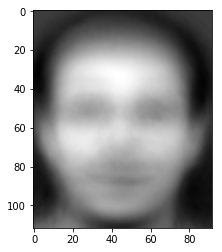

In [3]:
# Calculating the mean face vector
mean = np.divide(np.sum([i for i in train_imgs], 0), 320)

#Plotting the mean
print 'Mean of the training images is:'
plt.imshow(mean.reshape((112, 92)), cmap = 'gray', interpolation = 'bicubic')
plt.show()    

In [4]:
#Subtrabting mean from training images
norm_train_imgs = train_imgs - mean

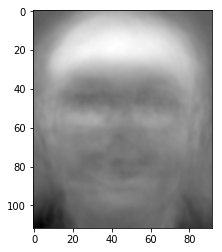

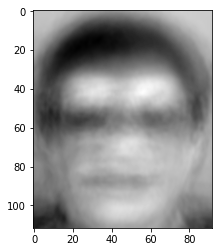

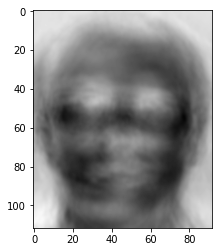

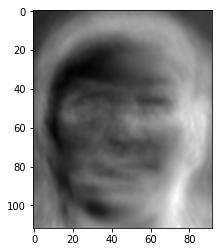

In [5]:
#Finding the eigenvectors using the method described in the paper
A = np.transpose(norm_train_imgs)
L = np.matmul(np.transpose(A), A)                                 #Calculating A^T.A instead of A.A^T

eig_val, eig_vec = np.linalg.eig(L)                               #Calculating eigenvectors and eigenvalues of L  

#Sorting eigenvectors and eigenvalues according to the eigenvalues in decresing order
eig_vec = eig_vec.transpose()                                     
inds = eig_val.argsort()[::-1]
eig_vec = eig_vec[inds]
eig_vec = np.array(eig_vec)
eig_val = eig_val[inds]

#Caculating eigen_faces
eig_faces = np.matmul(eig_vec, np.transpose(A))
norm = np.linalg.norm(eig_faces,axis=1)
eig_faces = eig_faces.transpose() / norm
eig_faces = eig_faces.transpose()

#Plotting top 4 eigen_faces
for i in range(4): 
    plt.imshow(eig_faces[i].reshape((112,92)), cmap = 'gray', interpolation = 'bicubic')
    plt.show()

In [6]:
k = 200                                                          #number of eigenfaces to be taken

#Finding weights of training images
weights = np.matmul(norm_train_imgs, np.transpose(eig_faces[:k]))

In [7]:
#Reading test images
test_imgs = []
for person in range(1, 41):
    for imgname in imgname_test[person-1]:
        test_imgs.append(imread('dataset/s' + str(person) + '/' + str(imgname) + '.pgm', 0).astype(np.float64).flatten())
        
#Adding images of unseen people to test set
for i in range(1,6):
    img = imread('dataset/f_img/' + str(i) + '.jpg', 0).flatten()
    test_imgs.append(img)
        
#Subtracting mean face from test images
norm_test_imgs = []
for i in range(len(test_imgs)):
    norm_img = test_imgs[i] - mean
    norm_test_imgs.append(norm_img)

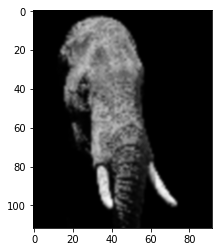

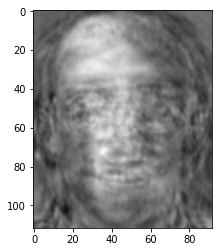

Euclidean distance between original and reconstructed image for non face image: 4033.1322811537743


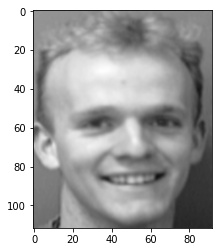

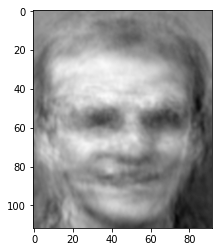

Euclidean distance between original and reconstructed image for face image: 1367.0087162798127


In [8]:
#Reconstructing a non face image 
img = imread('dataset/nf_img/5.jpg', 0)             #Loading the image
img = resize(img  , (92 , 112))                                 #Resizing it to the dimensions of training images
norm_img = img.flatten()-mean                                   #Subtracting mean
weight_img = np.matmul(norm_img, np.transpose(eig_faces[:k]))   #Calculating weights
#Reconstructing image
recon_img = np.zeros((10304,))                              
c=0
for i in eig_faces[:k]:
    recon_img += weight_img[c]*i
    c+=1
recon_img += mean
# Plotting the original and reconstructed images
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')       #Calculating weights
plt.show()
plt.imshow(recon_img.reshape((112,92)), cmap = 'gray', interpolation = 'bicubic')
plt.show() 
#Calcuting the Euclidean distance between the two images
print 'Euclidean distance between original and reconstructed image for non face image:', np.linalg.norm(img.flatten() - recon_img)

#Reconstructing a face image 
img_num = 9
weight_img = np.matmul(norm_test_imgs[img_num], np.transpose(eig_faces[:k]))
#Reconstructing image
recon_img = np.zeros((10304,))
c=0
for i in eig_faces[:k]:
    recon_img += weight_img[c]*i
    c+=1
recon_img += mean
# Plotting the original and reconstructed images
plt.imshow(test_imgs[img_num].reshape((112,92)), cmap = 'gray', interpolation = 'bicubic')
plt.show()
plt.imshow(recon_img.reshape((112,92)), cmap = 'gray', interpolation = 'bicubic')
plt.show()
#Calcuting the Euclidean distance between the two images
print 'Euclidean distance between original and reconstructed image for face image:', np.linalg.norm(test_imgs[img_num] - recon_img)

In [9]:
#Caculating threshold for face space using test images in ORL database and face images of unknown people
diff = []
for j in range(len(norm_test_imgs)):
    #Calculating weights
    weight_img = np.matmul(norm_test_imgs[j], np.transpose(eig_faces[:k]))
    
    #Reconstructing image
    recon_img = np.zeros((10304,))
    c=0
    for i in eig_faces[:k]:
        recon_img += weight_img[c]*i
        c+=1
    recon_img += mean
    
    #Finding Euclidean distance of original and reconstructed image
    diff.append(np.linalg.norm(test_imgs[j] - recon_img))

#Finding threshold
thr_face = max(diff)+100
print thr_face

3524.252044020602


In [10]:
#Adding non face images to test set
for i in range(1,6):
    img = imread('dataset/nf_img/' + str(i) + '.jpg', 0)
    img = resize(img,(92, 112))
    img = img.flatten()
    test_imgs.append(img)
    norm_img = img - mean
    norm_test_imgs.append(norm_img)

In [11]:
#calculating weights for test images
weights_test = np.matmul(norm_test_imgs, np.transpose(eig_faces[:k]))

#expected outcomes
exp_out = []

#expected outcomes for test images from ORL database
for i in range(1, 41):
    exp_out.append(i)
    exp_out.append(i)
    
#expected outcomes for images of unknown people
for i in range(5):
    exp_out.append('unk')
    
#expected outcomes for non face images
for i in range(5):
    exp_out.append('nf')

#threshold for face images 
threshold = 3600  # taken heuristically
out = [] #outcome
    
#Testing the model
error = 0
for i in range(len(test_imgs)):
    weight_img = weights_test[i]
    
    #Reconstructing image
    recon_img = np.zeros((10304,))                              
    c=0
    for j in eig_faces[:k]:
        recon_img += weight_img[c]*j
        c+=1
     
    #checking whether image is close to face space
    if  np.linalg.norm(norm_test_imgs[i] - recon_img) > thr_face:
        out.append('nf')               #it is a non face image
        if exp_out[i] != 'nf':
            error +=1
    #if image if near face space
    else:
        li={}
        for j in range(320):
            diff = np.linalg.norm(weights_test[i]-weights[j])
            if diff < threshold:
                li[diff] = j/8 + 1
        #if image is not near a face class then we give the tag 'unk'
        if li == {}:
            out.append('unk')
            if exp_out[i] != 'unk':
                error +=1
        #if image is near a face class then image is classified to belong to that class
        else:
            out.append(li[min(li.keys())])
            if li[min(li.keys())] != exp_out[i]:
                error += 1

#Printing outcome and expected outcome
print 'Outcome', 'Expected Outcome'
for i in range(len(test_imgs)):
    print out[i], '\t', exp_out[i]

#Evaluating the model
print 'Accuracy =', 100 - error*100.0/len(test_imgs),'%'


Outcome Expected Outcome
1 	1
1 	1
2 	2
2 	2
3 	3
3 	3
4 	4
4 	4
5 	5
5 	5
6 	6
6 	6
7 	7
7 	7
8 	8
8 	8
9 	9
9 	9
10 	10
10 	10
11 	11
11 	11
12 	12
12 	12
13 	13
13 	13
14 	14
14 	14
15 	15
15 	15
16 	16
16 	16
17 	17
17 	17
18 	18
18 	18
19 	19
19 	19
20 	20
20 	20
21 	21
21 	21
22 	22
22 	22
23 	23
23 	23
24 	24
24 	24
25 	25
25 	25
26 	26
26 	26
27 	27
27 	27
28 	28
28 	28
29 	29
29 	29
30 	30
30 	30
31 	31
31 	31
32 	32
32 	32
33 	33
33 	33
34 	34
34 	34
35 	35
35 	35
36 	36
36 	36
37 	37
37 	37
38 	38
38 	38
39 	39
39 	39
40 	40
40 	40
unk 	unk
unk 	unk
unk 	unk
unk 	unk
unk 	unk
nf 	nf
nf 	nf
nf 	nf
nf 	nf
nf 	nf
Accuracy = 100.0 %


original image


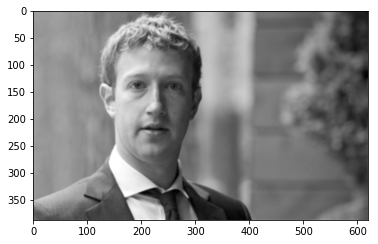

cropped face


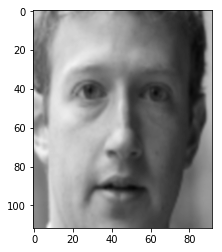

original image


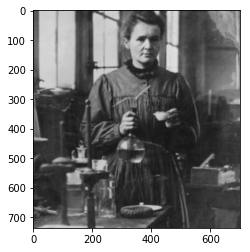

cropped face


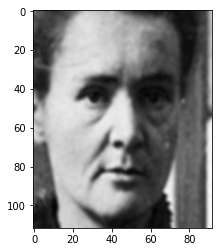

original image


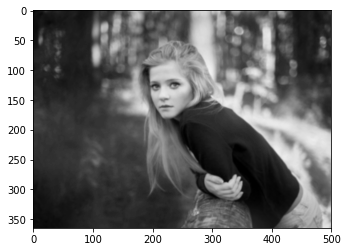

cropped face


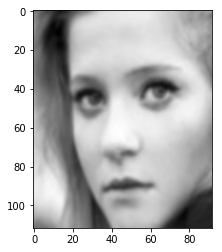

original image


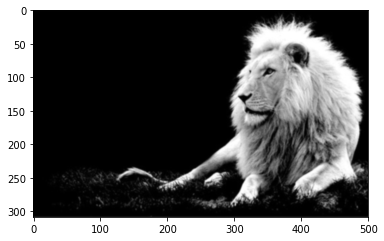

original image


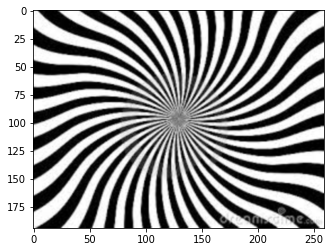

original image


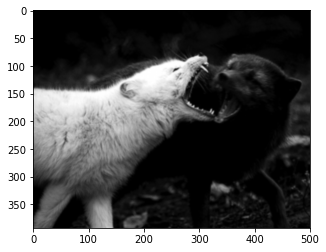

In [12]:
#Real time detection
face_cascade = CascadeClassifier('haarcascade_frontalface_default.xml')       #Using Haar Cascade to detect faces
c=0
for ca in range(1,7):
    inp_img = imread('dataset/fac_det/' + str(ca) + '.jpg', 0)    #Reading images
    imp_img = fastNlMeansDenoising(inp_img,None,10,7,21)                      #Removing noise to eliminate backgroung issues   
    faces = face_cascade.detectMultiScale(inp_img, 1.1, 3)                    #Detecting faces
    print 'original image'                                                    #Plotting original image
    plt.imshow(inp_img, cmap = 'gray', interpolation = 'bicubic')
    plt.show()
    for (x,y,w,h) in faces:
        img = inp_img[y:y+h, x:x+w]                                           #cropping detected faces                                        
        img = resize(img  , (92 , 112))                                       #resizing image
        c+=1
        print 'cropped face'
        plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')             #plotting resized detected face
        plt.show()
        imwrite('dataset/fac_det_cropimg/'+str(c)+'.jpg',img)     #saving detected face


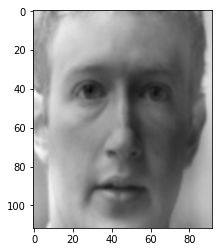

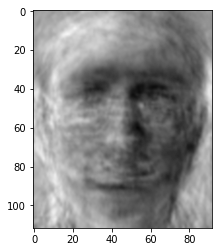

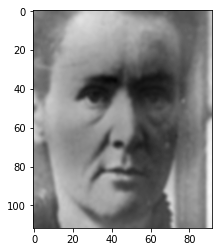

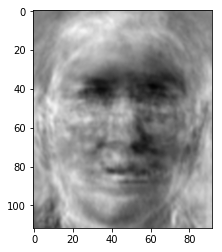

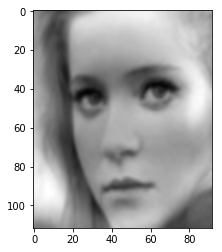

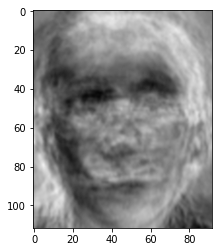

Outcome
unk
unk
unk


In [13]:
#Reading detected faces
fac_det_imgs = []
norm_fac_det_imgs = []
i = 1
while(1):
    try:
        img = imread('dataset/fac_det_cropimg/' + str(i) + '.jpg', 0)
        img = img.flatten()
        fac_det_imgs.append(img)
        norm_img = img - mean                           #subtracting mean face
        norm_fac_det_imgs.append(norm_img)
        i+=1
    except:
        break

#calculating weights for images
weights_fac_det = np.matmul(norm_fac_det_imgs, np.transpose(eig_faces[:k]))

#threshold for face images 
threshold = 3600  # taken heuristically
out = [] #outcome
    
#Testing the model
error = 0
for i in range(len(fac_det_imgs)):
    weight_img = weights_fac_det[i]
    
    #Reconstructing image
    recon_img = np.zeros((10304,))                              
    c=0
    for j in eig_faces[:k]:
        recon_img += weight_img[c]*j
        c+=1
     
    #checking whether image is close to face space
    if  np.linalg.norm(norm_fac_det_imgs[i] - recon_img) > thr_face:
        out.append('nf')               #it is a non face image
    #if image if near face space
    else:
        li={}
        for j in range(320):
            diff = np.linalg.norm(weights_fac_det[i]-weights[j])
            if diff < threshold:
                li[diff] = j/8 + 1
        #if image is not near a face class then we give the tag 'unk'
        if li == {}:
            out.append('unk')
        #if image is near a face class then image is classified to belong to that class
        else:
            out.append(li[min(li.keys())])
    #plotting image 
    plt.imshow(norm_fac_det_imgs[i].reshape((112,92)), cmap = 'gray', interpolation = 'bicubic')
    plt.show()
    #plotting reconstructed image
    plt.imshow(recon_img.reshape((112,92)), cmap = 'gray', interpolation = 'bicubic')
    plt.show()

#Printing outcome of detected faces
print 'Outcome'
for i in range(len(fac_det_imgs)):
    print out[i]

Thus the expected outcome is correct as images of these people are not in the database. For centered images of people in the database, non face images and centered images of people not in the database we tested the model before real time face recognition i.e. in the eleventh cell.  